In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install -q kagglehub

In [3]:
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("shashanknecrothapa/ames-housing-dataset")

print(f"Path to dataset files: {path}")


files = os.listdir(path)
print("Files found:", files)

csv_file = [f for f in files if f.endswith('.csv')][0]
full_file_path = os.path.join(path, csv_file)

df = pd.read_csv(full_file_path)

print(f"Shape: {df.shape}")
df.head()

100%|██████████| 185k/185k [00:00<00:00, 52.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/shashanknecrothapa/ames-housing-dataset/versions/1
Files found: ['AmesHousing.csv']
Shape: (2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

x = df.drop(['SalePrice', 'Order', 'PID'], axis = 1, errors = 'ignore')
y = df['SalePrice']

numerical_cols = x.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = x.select_dtypes(include=['object']).columns

#missing values
num_imputer = SimpleImputer(strategy='median')
x[numerical_cols] = num_imputer.fit_transform(x[numerical_cols])

#fill text with most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
x[categorical_cols] = cat_imputer.fit_transform(x[categorical_cols])

#convert text to numbers
#one hot encoding
x = pd.get_dummies(x, columns=categorical_cols, drop_first=True)

In [5]:
print(f"New Feature Count: {x.shape[1]} columns")

New Feature Count: 260 columns


In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
print(f"Training shapes: X={x_train.shape}, y={y_train.shape}")
print(f"Testing shapes:  X={x_test.shape}, y={y_test.shape}")

Training shapes: X=(2344, 260), y=(2344,)
Testing shapes:  X=(586, 260), y=(586,)


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

In [8]:
predictions = model.predict(x_test)

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Average Error: ${mae:,.0f}")
print(f"Accuracy (R2 Score): {r2:.2f} (1.0 is perfect)")

Average Error: $15,828
Accuracy (R2 Score): 0.91 (1.0 is perfect)


/tmp/ipython-input-2802148222.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


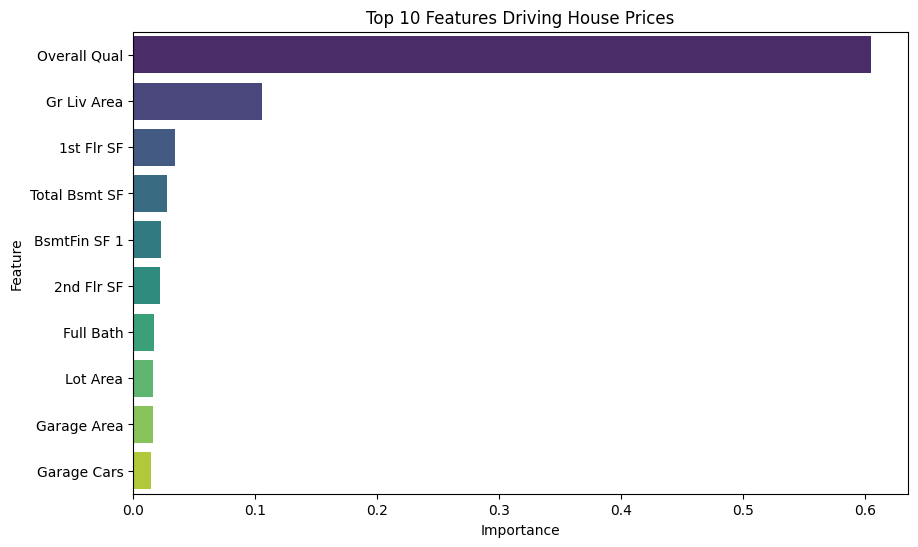

Top 10 Features:
 ['Overall Qual' 'Gr Liv Area' '1st Flr SF' 'Total Bsmt SF' 'BsmtFin SF 1'
 '2nd Flr SF' 'Full Bath' 'Lot Area' 'Garage Area' 'Garage Cars']


In [9]:
# Get feature importances from the trained model
importances = model.feature_importances_

# Create a DataFrame to view them
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualize the Top 10
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Features Driving House Prices')
plt.show()

print("Top 10 Features:\n", feature_importance_df.head(10)['Feature'].values)

In [10]:

selected_features = [
    'Overall Qual',  # Rates the overall material and finish of the house
    'Gr Liv Area',   # Above grade (ground) living area square feet
    'Total Bsmt SF', # Total square feet of basement area
    '1st Flr SF',    # First Floor square feet
    'Garage Cars',   # Size of garage in car capacity
    'Garage Area',   # Size of garage in square feet
    'Year Built',    # Original construction date
    'Full Bath',     # Full bathrooms above grade
    'Year Remod/Add',# Remodel date (same as construction date if no remodeling or additions)
    'Mas Vnr Area',  # Masonry veneer area in square feet
    'Fireplaces',    # Number of fireplaces
    'BsmtFin SF 1'   # Type 1 finished square feet
]


final_features = [col for col in selected_features if col in df.columns]

print(f"Retraining with {len(final_features)} features: {final_features}")


X_lite = df[final_features].copy()
y_lite = df['SalePrice']


X_lite = X_lite.fillna(0)

#Train the Lite Model
model_lite = RandomForestRegressor(n_estimators=100, random_state=42)
model_lite.fit(X_lite, y_lite)

print("✅ 'Lite' Model Trained!")

Retraining with 12 features: ['Overall Qual', 'Gr Liv Area', 'Total Bsmt SF', '1st Flr SF', 'Garage Cars', 'Garage Area', 'Year Built', 'Full Bath', 'Year Remod/Add', 'Mas Vnr Area', 'Fireplaces', 'BsmtFin SF 1']
✅ 'Lite' Model Trained!


In [11]:
import joblib
import json
from google.colab import files

# 1. Save the model
joblib.dump(model_lite, 'ames_housing_model.pkl')

# 2. Save the column names (so the web app knows what inputs to create)
with open('columns.json', 'w') as f:
    json.dump(final_features, f)

# 3. Download the files to your local computer
files.download('ames_housing_model.pkl')
files.download('columns.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>